## Note: This notebook will run about 1 hrs and 23 mins on my computer (Intel(R) Core(TM) i7-10875H CPU @ 2.30GHz; RAM: 32.0 GB).

In [18]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
import xgboost
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE,RandomOverSampler,ADASYN,SVMSMOTE
from imblearn.pipeline import Pipeline as imbpipeline
import seaborn as sns
import skopt
from skopt import BayesSearchCV
from helper_function import bayes_tuning,grid_tuning

In [23]:
#ingore warnings
warnings.filterwarnings("ignore")
xgboost.set_config(verbosity=0)
#to show more rows and columns in pandas Dataframe
pd.set_option('display.max_columns',200)
pd.set_option('display.max_rows',200)

# Data Preprocessing

In [42]:
#loading data
dataset_c=pd.read_csv('data/hosp_c.csv')
dataset_q=pd.read_csv('data/quality.csv')

In [45]:
dataset_q.drop(columns=['Unnamed: 0'],inplace=True)
dataset_c.drop(columns=['Unnamed: 0'],inplace=True)
col_list=list(dataset_c.drop(columns=['year','id','Closure']).columns)

In [33]:

dataset_=pd.concat([dataset_c[dataset_c['year']==2013],dataset_c[dataset_c['year']==2014],dataset_c[dataset_c['year']==2015]])

In [36]:
#match two data files
dataset=pd.merge(dataset_q, dataset_c, on=["id","year"], how="inner")
dataset.drop(columns=['Closure_x', 'year', 'id'],inplace=True)

In [37]:
dataset

,COMP_HIP_KNEE,MORT_30_AMI,MORT_30_COPD,MORT_30_HF,MORT_30_PN,MORT_30_STK,PSI_12_POSTOP_PULMEMB_DVT,PSI_14_POSTOP_DEHIS,PSI_15_ACC_LAC,PSI_4_SURG_COMP,PSI_6_IAT_PTX,PSI_90_SAFETY,READM_30_AMI,READM_30_COPD,READM_30_HF,READM_30_HIP_KNEE,READM_30_HOSP_WIDE,READM_30_PN,READM_30_STK,Closure_x,year,id,dshpct,ime1,dsh1,gme_part_a,gme_part_b,beds,bed_days,medicare_days,medicaid_days,days,employees,medicare_disch,medicaid_disch,discharges,ind_dsh,ind_teaching,efficiency,utilization,overall,doc_communicate,nurse_communicate,help_quick,staff_explain,pain_control,area_quiet,room_clean,discharge_info,recommend,survey_response_rate,mortality,safety,readmin,patient_exp,effective,timely,hsanum,prop_discharges,rural_urban,pop,unemp,poverty,under_65,prop_phy_pcp,prop_md_pcp,prop_pcp,prop_gi,prop_gen_int,prop_hosp,prop_hosp_short,prop_cah,prop_hosp_adm,prop_hosp_adm_short,prop_hosp_bed,prop_hosp_bed_short,prop_days_inp,prop_days_inp_short,prop_days_inp_med,Closure_y
0,3.8,12.5,9.3,12.4,15.5,15.4,3.32,2.72,1.35,168.260000,0.36,0.68,16.500000,21.1,21.4,5.1,15.4,18.7,12.7,0.0,2015,10001,0.123400,4.768587e+06,1.724846e+06,1.410848e+06,739624.474838,400.0,146000.0,43678.0,9014.0,89693.0,2379.500000,8329.0,2849.0,18484.0,1.0,0.0,46.210000,0.614336,71.000000,81.000000,75.000000,58.000000,61.000000,66.000000,66.000000,66.000000,85.000000,76.000000,27.000000,2.000000,3.000000,1.666667,1.000000,2.000000,2.000000,1026.0,3151.090243,3.0,102369.0,8.1,17.9,84.043998,0.000762,0.000723,0.003829,0.000068,0.000342,0.000049,0.000020,0.0,0.318573,0.298743,0.007356,0.006398,1.704217,1.412049,0.753724,0.0
1,3.0,16.0,7.6,15.5,20.8,15.5,5.63,2.11,1.25,179.050000,0.47,0.85,16.700000,18.0,21.9,5.7,14.9,16.4,13.4,0.0,2015,10005,0.127200,2.819540e+06,7.592660e+05,1.019695e+06,666712.679075,204.0,74460.0,18262.0,6598.0,38465.0,1068.400024,3739.0,1383.0,9368.0,1.0,0.0,45.921569,0.516586,75.000000,86.000000,82.000000,65.000000,71.000000,73.000000,71.000000,71.000000,89.000000,76.000000,34.000000,1.000000,2.000000,3.000000,2.000000,2.000000,3.000000,1012.0,625.680148,4.0,94166.0,8.6,19.4,83.464308,0.000552,0.000520,0.001211,0.000011,0.000085,0.000021,0.000021,0.0,0.113194,0.113194,0.002145,0.002145,0.420545,0.420545,0.239588,0.0
2,3.8,16.7,7.1,15.6,18.2,17.9,3.85,2.50,1.93,198.330000,0.41,0.91,16.100000,19.8,20.6,5.0,15.4,17.9,12.0,0.0,2015,10006,0.096800,2.914679e+05,1.072119e+06,9.451234e+05,694455.979380,358.0,131028.0,31348.0,9264.0,60737.0,971.119995,5992.0,2055.0,12713.0,1.0,0.0,35.511173,0.464812,63.000000,84.000000,82.000000,67.000000,66.000000,71.000000,70.000000,60.000000,82.000000,63.000000,23.000000,1.000000,2.000000,1.666667,1.000000,2.000000,3.000000,1036.0,625.680148,3.0,92781.0,8.3,17.6,81.355019,0.000496,0.000474,0.001918,0.000022,0.000216,0.000011,0.000011,0.0,0.123032,0.123032,0.002996,0.002996,0.551158,0.551158,0.297248,0.0
3,3.1,14.3,9.3,14.4,18.8,16.6,4.57,1.88,1.20,141.205407,0.40,0.79,16.930460,19.9,21.1,4.8,16.6,17.3,12.7,0.0,2015,10007,0.030100,1.036045e+06,2.727200e+04,1.014589e+06,614308.268276,45.0,16425.0,3448.0,517.0,5108.0,135.310000,813.0,198.0,1379.0,1.0,0.0,30.644440,0.310989,66.000000,88.000000,76.000000,60.000000,62.000000,63.000000,74.000000,68.000000,82.000000,66.000000,31.000000,1.666667,2.014161,1.000000,2.000000,1.000000,3.000000,25077.0,1215.265000,2.0,143702.0,8.4,16.3,83.470170,0.000687,0.000600,0.002303,0.000030,0.000232,0.000025,0.000016,0.0,0.113323,0.104985,0.003260,0.002668,0.703786,0.547500,0.241704,0.0
4,3.1,14.3,8.2,12.7,15.7,14.9,4.20,1.88,1.41,136.989470,0.41,0.90,17.048832,19.2,23.1,4.8,15.7,16.0,12.8,0.0,2015,10008,0.127700,4.940775e+05,2.792000e+04,8.793507e+05,584936.713143,29.0,10585.0,939.0,192.0,1836.0,82.709999,218.0,77.0,352.0,1.0,0.0,12.137931,0.173453,65.000000,92.000000,82.000000,83.000000,47.000000,77.000000,68.000000,71.000000,86.000000,66.000000,26.000000,2.000000,2.048453,2.333333,2.000000,2.000000,3.000000,1056.0,2051.974581,8.0,13911.0,8.7,20.3,83.322550,0.000216,0.000216,0.000503,0.000000,0.000072,0.000

In [49]:
# matched data without quality variables
dataset_=pd.DataFrame(dataset,columns=col_list)
dataset_=dataset_.assign(Closure=dataset['Closure_y'])
dataset_

In [51]:
dataset=dataset.to_numpy()
dataset_=dataset_.to_numpy()

# hyperparameter tuning

## without quality variables

In [52]:
X_train, X_test, y_train, y_test = train_test_split(dataset_[:,:-1],
                                                    dataset_[:,-1],
                                                    test_size=0.1,
                                                    stratify=dataset_[:,-1]
                                                    )
stratified_kfold = StratifiedKFold(n_splits=10)

In [56]:
classifier=XGBClassifier(booster='gbtree',tree_method='hist')
param_space={'classifier__learning_rate': (0.01, 1.0, 'log-uniform'),
             'classifier__min_child_weight': (0, 10),
             'classifier__max_depth': (1, 100),
             'classifier__max_delta_step': (0, 10),
             'classifier__subsample': (0.01, 1.0, 'uniform'),             
             'classifier__alpha': (1e-5, 1.0, 'log-uniform'),
             'classifier__n_estimators': (50, 600)   
        }

oversampling=None
cv_score_xg_,test_score_xg_,list_best_cv_xg_=bayes_tuning(X_train, y_train,X_test, y_test,stratified_kfold,oversampling,classifier,param_space) 
       
oversampling=RandomOverSampler()
cv_score_xg_r_,test_score_xg_r_,list_best_cv_xg_r_=bayes_tuning(X_train, y_train,X_test, y_test,stratified_kfold,oversampling,classifier,param_space)

oversampling=SMOTE()
cv_score_xg_s_,test_score_xg_s_,list_best_cv_xg_s_=bayes_tuning(X_train, y_train,X_test, y_test,stratified_kfold,oversampling,classifier,param_space)

oversampling=ADASYN()
cv_score_xg_a_,test_score_xg_a_,list_best_cv_xg_a_=bayes_tuning(X_train, y_train,X_test, y_test,stratified_kfold,oversampling,classifier,param_space)

oversampling=SVMSMOTE()
cv_score_xg_svm_,test_score_xg_svm_,list_best_cv_xg_svm_=bayes_tuning(X_train, y_train,X_test, y_test,stratified_kfold,oversampling,classifier,param_space)

Classifier: XGBClassifier(base_score=None, booster='gbtree', colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method='hist',
              validate_parameters=None, verbosity=None)
Over-sampling strategy: None
Cross-validation score: 0.24666666666666667
Test score: 0.0
Best parameters: {'classifier__alpha': 0.0187879292979953, 'classifier__learning_rate': 1.0, 'classifier__max_delta_step': 10, 'classifier__max_depth': 100, 'classifier__min_child_weight': 1, 'classifier__n_estimators': 173, 'classifier__subsample': 1.0}

Class

## combine with quality variables

In [17]:
X_train, X_test, y_train, y_test = train_test_split(dataset[:,:-1],
                                                    dataset[:,-1],
                                                    test_size=0.1,
                                                    stratify=dataset[:,-1]
                                                    )
stratified_kfold = StratifiedKFold(n_splits=10)

In [24]:
classifier=XGBClassifier(booster='gbtree',tree_method='hist')
param_space={'classifier__learning_rate': (0.01, 1.0, 'log-uniform'),
             'classifier__min_child_weight': (0, 10),
             'classifier__max_depth': (1, 100),
             'classifier__max_delta_step': (0, 10),
             'classifier__subsample': (0.01, 1.0, 'uniform'),             
             'classifier__alpha': (1e-5, 1.0, 'log-uniform'),
             'classifier__n_estimators': (50, 600)   
        }

oversampling=None
cv_score_xg,test_score_xg,list_best_cv_xg=bayes_tuning(X_train, y_train,X_test, y_test,stratified_kfold,oversampling,classifier,param_space) 
       
oversampling=RandomOverSampler()
cv_score_xg_r,test_score_xg_r,list_best_cv_xg_r=bayes_tuning(X_train, y_train,X_test, y_test,stratified_kfold,oversampling,classifier,param_space)

oversampling=SMOTE()
cv_score_xg_s,test_score_xg_s,list_best_cv_xg_s=bayes_tuning(X_train, y_train,X_test, y_test,stratified_kfold,oversampling,classifier,param_space)

oversampling=ADASYN()
cv_score_xg_a,test_score_xg_a,list_best_cv_xg_a=bayes_tuning(X_train, y_train,X_test, y_test,stratified_kfold,oversampling,classifier,param_space)

oversampling=SVMSMOTE()
cv_score_xg_svm,test_score_xg_svm,list_best_cv_xg_svm=bayes_tuning(X_train, y_train,X_test, y_test,stratified_kfold,oversampling,classifier,param_space)

Classifier: XGBClassifier(base_score=None, booster='gbtree', colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method='hist',
              validate_parameters=None, verbosity=None)
Over-sampling strategy: None
Cross-validation score: 0.47904761904761906
Test score: 0.5714285714285715
Best parameters: {'classifier__alpha': 0.013916566786656556, 'classifier__learning_rate': 0.33655602459055045, 'classifier__max_delta_step': 10, 'classifier__max_depth': 1, 'classifier__min_child_weight': 0, 'classifier__n_estimators': 600, 'clas

# result plot

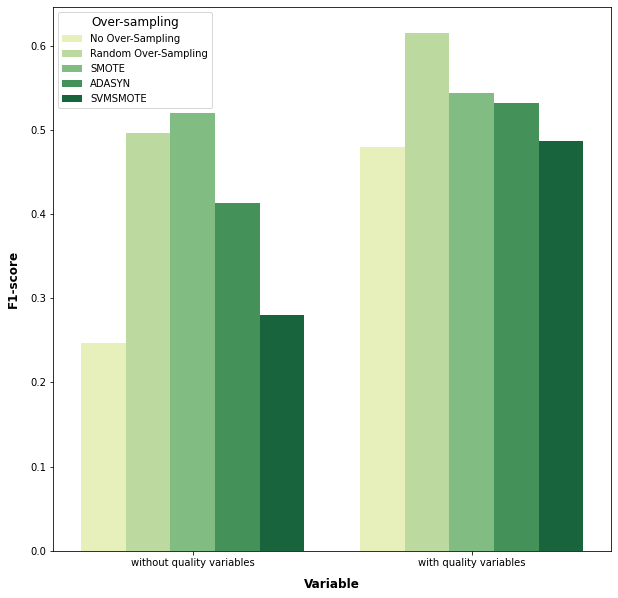

In [61]:
models_comparsion = pd.DataFrame({
    'Variable': ['without quality variables','with quality variables'],
    'No Over-Sampling':[cv_score_xg_,cv_score_xg],
    'Random Over-Sampling':[cv_score_xg_r_,cv_score_xg_r],
    'SMOTE': [cv_score_xg_s_,cv_score_xg_s],
    'ADASYN': [cv_score_xg_a_,cv_score_xg_a],
    'SVMSMOTE':[cv_score_xg_svm_,cv_score_xg_svm]
    })
models_comparsion_barplot=models_comparsion.melt(id_vars='Variable').rename(columns={'variable':'Oversampling','value':'f1-score'})
fig,_=plt.subplots(figsize=(10, 10))
sns.barplot(x="Variable", y='f1-score',hue='Oversampling',data=models_comparsion_barplot,palette="YlGn")
plt.xlabel('Variable',labelpad=10,fontsize='large',fontweight='bold')
plt.ylabel('F1-score',labelpad=10,fontsize='large',fontweight='bold')
plt.legend(title='Over-sampling',title_fontsize='large')
plt.title('')
plt.show()